# FA7 Building a Time Series and Forecasting Model
### CSS182-3_BM1 
Nathan Joseph L. Perez
<br>Artryan Nero A. Logarta

### Introduction

We developed a time series forecasting model to predict commodity prices using Facebook Prophet. The dataset was preprocessed by ensuring proper date formatting and handling missing values. We then applied Prophet forecasting to each commodity, allowing the model to automatically detect trends and seasonal patterns. Our forecast extended 730 days (2 years) into the future, providing long-term price predictions. To evaluate the model’s performance, we calculated Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), which indicated a reasonable level of accuracy. We visualized the actual vs. forecasted prices, highlighting key trends and confidence intervals. This model can be further improved by incorporating external factors such as economic indicators and supply-demand data or by fine-tuning hyperparameters for greater accuracy.

## Import the Necessary Libraries
- pandas (pd) – A powerful data manipulation library used for handling structured data, such as time series data in DataFrames.

- numpy (np) – A fundamental package for numerical computing, providing support for arrays, mathematical operations, and statistical functions.

- seaborn (sns) – A statistical data visualization library based on Matplotlib, used for creating aesthetically pleasing and informative plots.

- matplotlib.pyplot (plt) – A core visualization library in Python, useful for creating static, animated, and interactive plots.

- statsmodels.tsa.seasonal (seasonal_decompose) – A function used for decomposing time series data into trend, seasonal, and residual components.

- statsmodels.tsa.stattools (adfuller) – Provides the Augmented Dickey-Fuller (ADF) test, which is used to check if a time series is stationary.

- prophet (Prophet) – A forecasting tool developed by Facebook (Meta), useful for modeling time series data with trends, seasonality, and holiday effects.

- sklearn.metrics (mean_absolute_error, mean_squared_error) – Functions from Scikit-learn used to evaluate model performance by calculating error metrics for predictions.

- warnings – A built-in Python module to handle and suppress warning messages.

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


## Load the Data

In [16]:
fuels_df = pd.read_csv('fuels_data.csv')
fuels_df.head()

,ticker,commodity,date,open,high,low,close,volume
0,CL=F,Crude Oil,2000-08-23,31.950001,32.799999,31.950001,32.049999,79385
1,CL=F,Crude Oil,2000-08-24,31.900000,32.240002,31.400000,31.629999,72978
2,CL=F,Crude Oil,2000-08-25,31.700001,32.099998,31.320000,32.049999,44601
3,CL=F,Crude Oil,2000-08-28,32.040001,32.919998,31.860001,32.869999,46770
4,CL=F,Crude Oil,2000-08-29,32.820000,33.029999,32.560001,32.720001,49131


In [17]:
fuels_df.tail(10)

,ticker,commodity,date,open,high,low,close,volume
28065,BZ=F,Brent Crude Oil,2024-06-10,79.410004,82.160004,79.349998,81.629997,36413
28066,BZ=F,Brent Crude Oil,2024-06-11,81.970001,82.360001,81.199997,81.919998,35178
28067,BZ=F,Brent Crude Oil,2024-06-12,82.120003,83.339996,81.970001,82.599998,40802
28068,BZ=F,Brent Crude Oil,2024-06-13,82.540001,83.040001,81.800003,82.750000,39191
28069,BZ=F,Brent Crude Oil,2024-06-14,82.139999,83.389999,81.919998,82.620003,39346
28070,BZ=F,Brent Crude Oil,2024-06-17,82.620003,84.550003,82.110001,84.250000,32978
28071,BZ=F,Brent Crude Oil,2024-06-18,84.400002,85.480003,83.660004,85.330002,45690
28072,BZ=F,Brent Crude Oil,2024-06-20,85.379997,85.970001,84.889999,85.709999,52543
28073,BZ=F,Brent Crude Oil,2024-06-21,85.680000,86.230003,84.839996,85.239998,25055
28074,BZ=F,Brent Crude Oil,2024-06-24,85.089996,86.169998,84.730003,86.010002,25055


## Data Preprocessing

In [18]:
fuels_df.shape

(28075, 8)

In [19]:
fuels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28075 entries, 0 to 28074
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     28075 non-null  object 
 1   commodity  28075 non-null  object 
 2   date       28075 non-null  object 
 3   open       28075 non-null  float64
 4   high       28075 non-null  float64
 5   low        28075 non-null  float64
 6   close      28075 non-null  float64
 7   volume     28075 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 1.7+ MB


In [20]:
fuels_df.nunique()

ticker           5
commodity        5
date          5990
open         17035
high         17147
low          16947
close        19185
volume       25107
dtype: int64

In [21]:
fuels_df.describe()

,open,high,low,close,volume
count,28075.000000,28075.000000,28075.000000,28075.000000,2.807500e+04
mean,27.288994,27.680580,26.873389,27.287224,1.059926e+05
std,36.085625,36.540236,35.599243,36.089001,1.484400e+05
min,-14.000000,0.507000,-40.320000,-37.630001,0.000000e+00
25%,2.031000,2.060550,1.998200,2.031250,2.641100e+04
50%,3.374000,3.450000,3.301000,3.375900,4.903300e+04
75%,54.895000,55.745001,53.910000,54.900000,1.147245e+05
max,146.080002,147.429993,144.270004,146.080002,2.288230e+06


We checked for any missing values in the dataset. The output confirms that there are no missing values, allowing us to proceed without imputation.

In [22]:
fuels_df.isnull().sum()

ticker       0
commodity    0
date         0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

To ensure proper time series analysis, we converted the 'date' column to a datetime format and set it as the index for the dataset. This allows efficient sorting, filtering, and visualization over time. We determined the earliest and latest dates in the dataset revealing a time range from August 23, 2000, to June 24, 2024. To maintain chronological order, we sorted the dataset by date.

In [23]:
fuels_df['date'] = pd.to_datetime(fuels_df['date'])
fuels_df.set_index('date', inplace=True)

In [24]:
fuels_df.index.min(), fuels_df.index.max()

(Timestamp('2000-08-23 00:00:00'), Timestamp('2024-06-24 00:00:00'))

In [25]:
fuels_df.sort_index(inplace=True)

In [26]:
fuels_df.head(10)

,ticker,commodity,open,high,low,close,volume
date,,,,,,,
2000-08-23,CL=F,Crude Oil,31.950001,32.799999,31.950001,32.049999,79385
2000-08-24,CL=F,Crude Oil,31.900000,32.240002,31.400000,31.629999,72978
2000-08-25,CL=F,Crude Oil,31.700001,32.099998,31.320000,32.049999,44601
2000-08-28,CL=F,Crude Oil,32.040001,32.919998,31.860001,32.869999,46770
2000-08-29,CL=F,Crude Oil,32.820000,33.029999,32.560001,32.720001,49131
2000-08-30,NG=F,Natural Gas,4.650000,4.815000,4.630000,4.805000,34954
2000-08-30,CL=F,Crude Oil,32.750000,33.400002,32.099998,33.400002,79214
2000-08-31,CL=F,Crude Oil,33.250000,33.700001,32.970001,33.099998,56895
2000-08-31,NG=F,Natural Gas,4.820000,4.870000,4.740000,4.780000,25787


## Visualization of Commodity Closing Prices Over Time

This graph displays the historical closing prices of multiple commodities, including Crude Oil, Natural Gas, Heating Oil, RBOB Gasoline, and Brent Crude Oil. The data is plotted over time to observe price fluctuations, trends, and market patterns. Notably, Crude Oil and Brent Crude Oil exhibit significant price volatility, while other commodities show relatively stable trends. This visualization helps in identifying long-term patterns, price peaks, and potential forecasting opportunities.

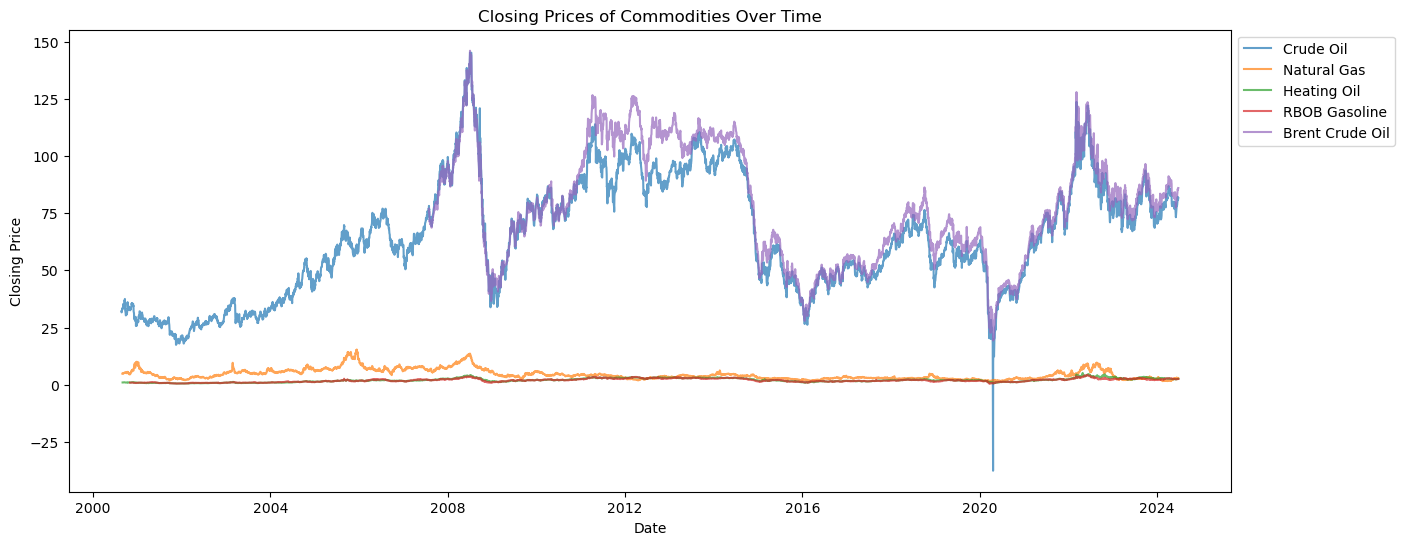

In [ ]:
plt.figure(figsize=(15,6))
for commodity in fuels_df['commodity'].unique():
    subset = fuels_df[fuels_df['commodity'] == commodity]
    plt.plot(subset.index, subset['close'], label= commodity, alpha=0.7)

plt.title("Closing Prices of Commodities Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

## Seasonal Decomposition of Commodity Prices
This process performs seasonal decomposition on the closing prices of different commodities to analyze their trend, seasonality, residual components. The dataset is filtered by each commodity, selecting only the closing price.
<br>
<br>
Using the additive decomposition model with a 365-day seasonal period, the time series is split into:
- Trend Component: This represents the long-term movement of prices
- Seasonal Component: This captures the repeating patterns (yearly fluctuations)
- Residual Component: This represents the noise or irregular variations
    


In [65]:
commodities = fuels_df['commodity'].unique()

Seasonal Decomposition for Crude Oil


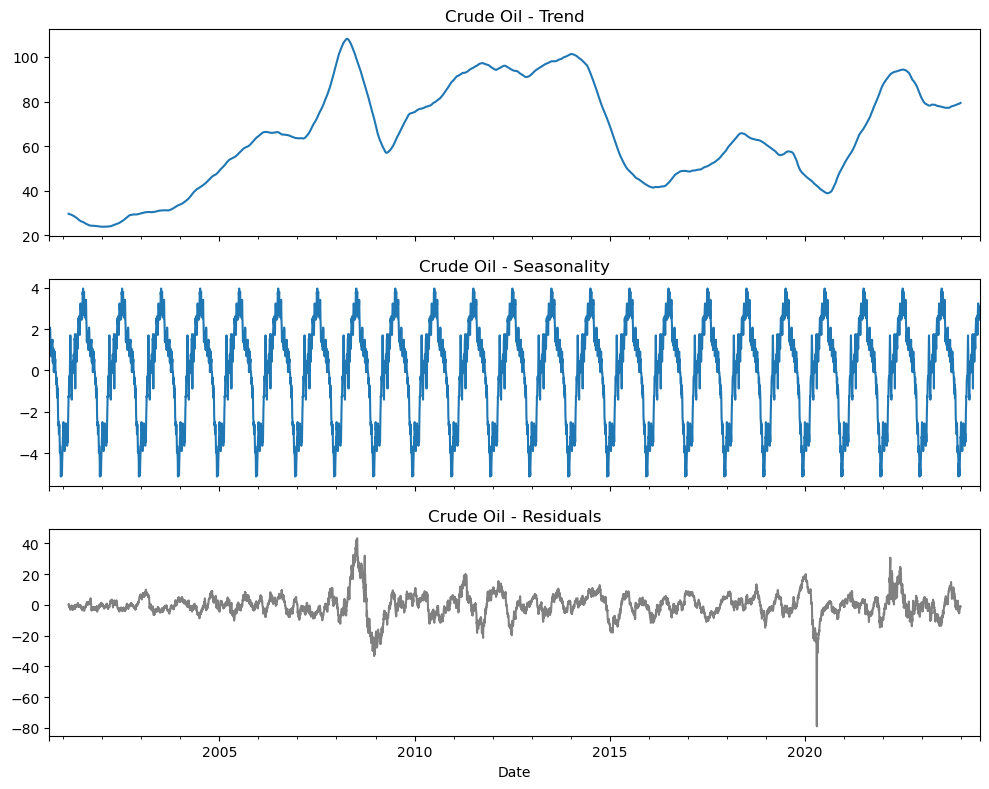

Seasonal Decomposition for Natural Gas


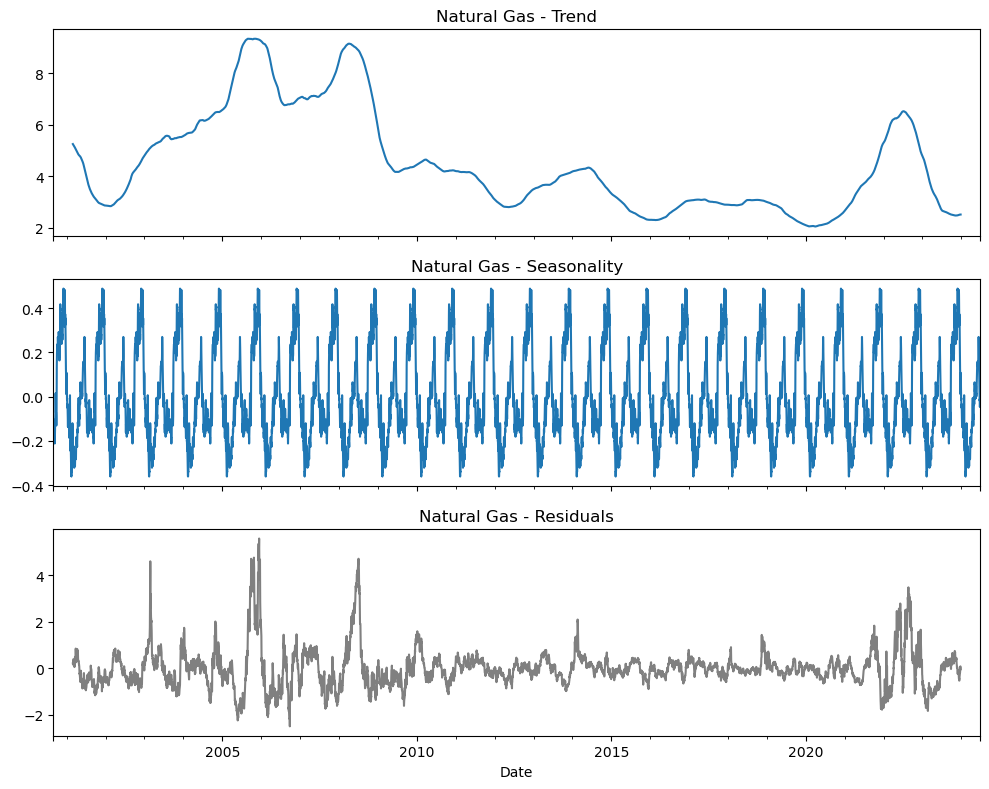

Seasonal Decomposition for Heating Oil


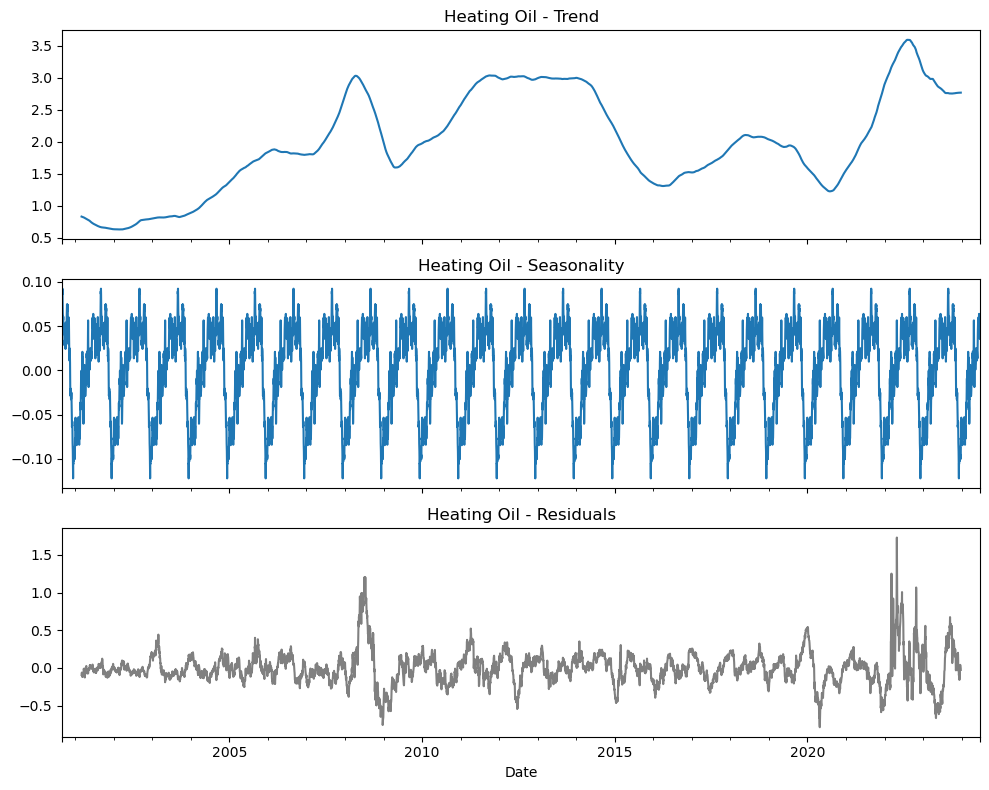

Seasonal Decomposition for RBOB Gasoline


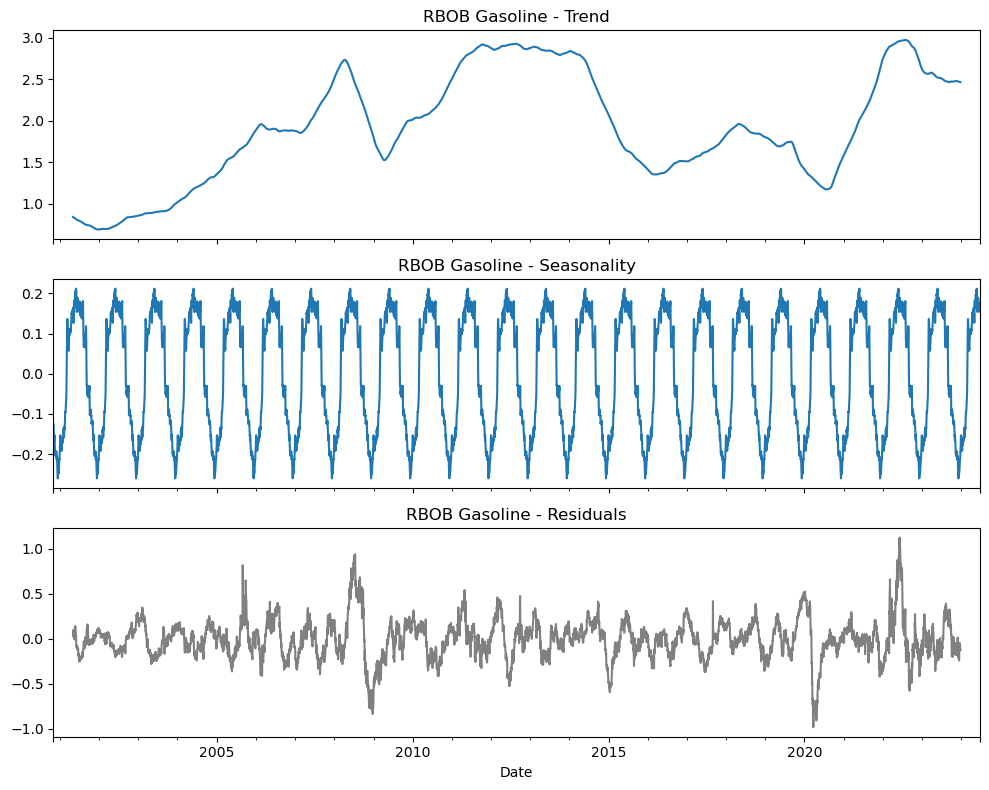

Seasonal Decomposition for Brent Crude Oil


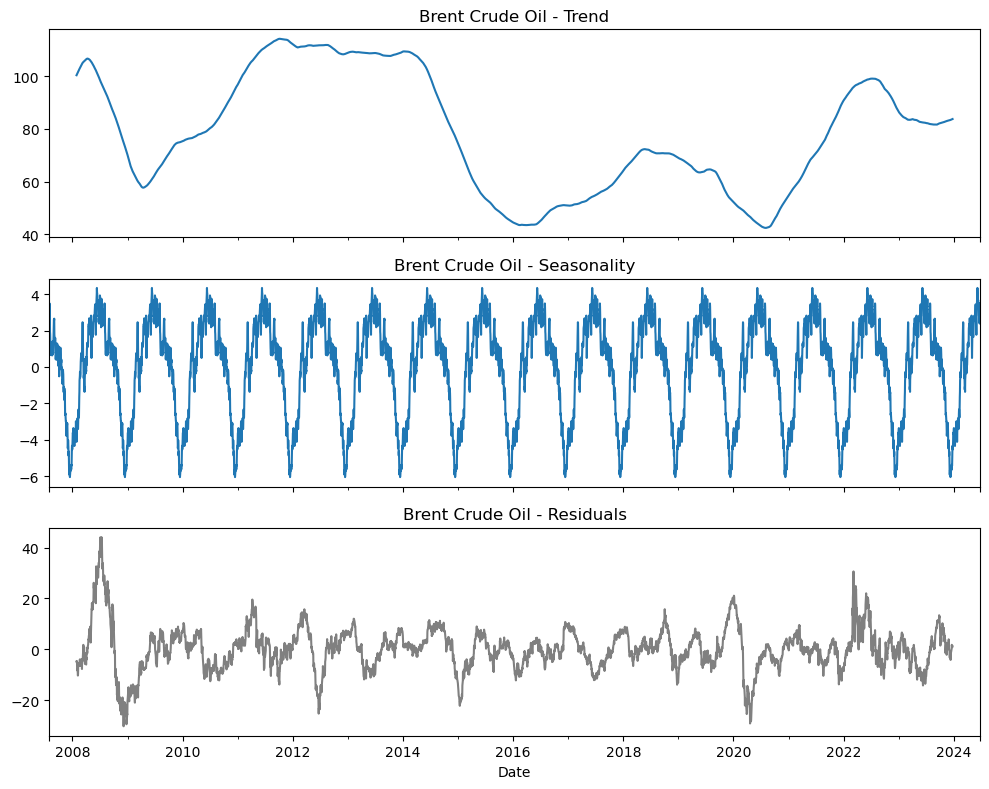

In [ ]:
# Loop through each commodity
for commodity in commodities:
    print(f"Seasonal Decomposition for {commodity}")

    # Extract data for the current commodity (without re-setting index)
    commodity_data = fuels_df[fuels_df['commodity'] == commodity]['close']
    commodity_data = commodity_data.asfreq('D').interpolate()

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(commodity_data, model='additive', period=365)

    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    decomposition.trend.plot(ax=axes[0], title=f'{commodity} - Trend')
    decomposition.seasonal.plot(ax=axes[1], title=f'{commodity} - Seasonality')
    decomposition.resid.plot(ax=axes[2], title=f'{commodity} - Residuals', color='gray')

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


## Prophet-Based Time Series Forecasting
This implementation utilizes Facebook Prophet to forecast the closing prices of different commodities over a 2-year period (730 days). This model helps in understanding commodity price trends, planning investments, and making data-driven decisions.

In [67]:
# Forecast horizon: 730 days (2 years)
forecast_horizon = 730

# Dictionary to store forecasts
prophet_forecasts = {}

The process begins by extracting and renaming the necessary columns to match Prophet's required format, where the date column is labeled as 'ds' and the closing price as 'y'. A Prophet model is then trained with yearly and weekly seasonality, along with a changepoint prior scale of 0.05 to detect trend shifts. The model generates future predictions for each commodity, storing the forecasted values along with confidence intervals.
<br>

To assess the accuracy of the forecasts, the model evaluates Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) by comparing the last 730 days of actual data with the first 730 days of forecasted values. Finally, the results are visualized by plotting the actual vs. forecasted prices, where the red shaded area represents the confidence interval, indicating the uncertainty in long-term predictions. This model provides valuable insights into commodity price trends, helping in financial analysis and decision-making

07:46:50 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for Crude Oil using Prophet...


07:46:53 - cmdstanpy - INFO - Chain [1] done processing


Crude Oil - MAE: 55.17, RMSE: 56.47


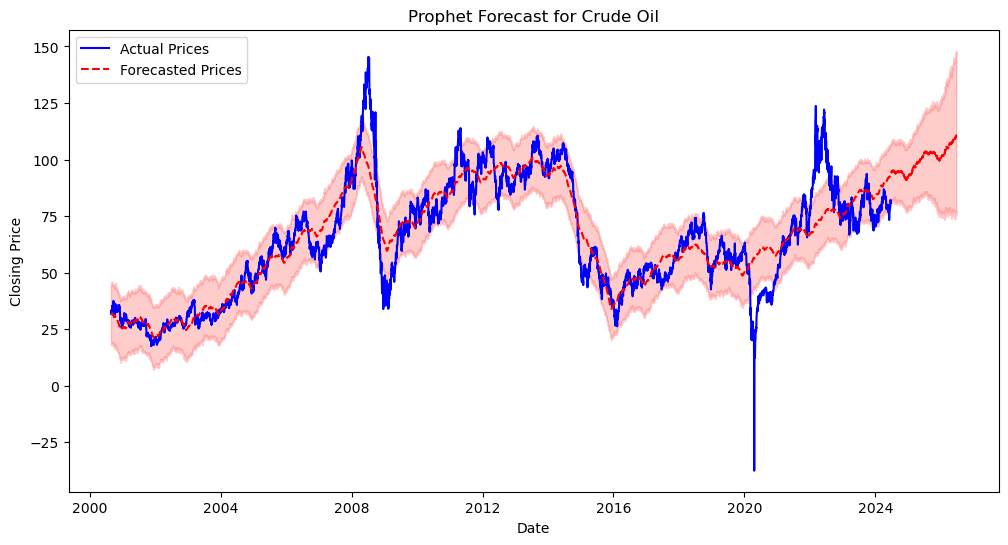

07:46:54 - cmdstanpy - INFO - Chain [1] start processing


Forecasting for Natural Gas using Prophet...


07:46:55 - cmdstanpy - INFO - Chain [1] done processing


Natural Gas - MAE: 1.78, RMSE: 2.16


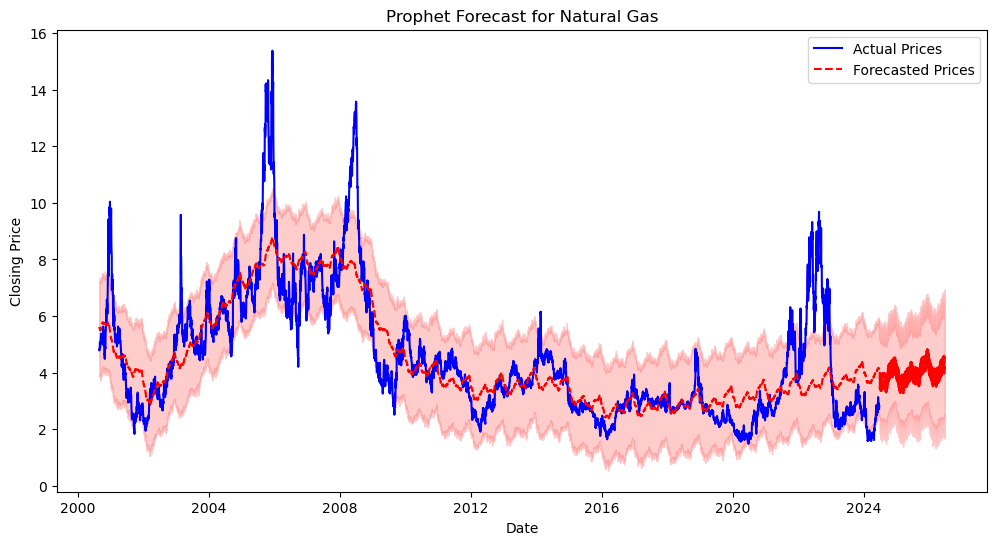

Forecasting for Heating Oil using Prophet...


07:46:56 - cmdstanpy - INFO - Chain [1] start processing
07:46:59 - cmdstanpy - INFO - Chain [1] done processing


Heating Oil - MAE: 2.20, RMSE: 2.28


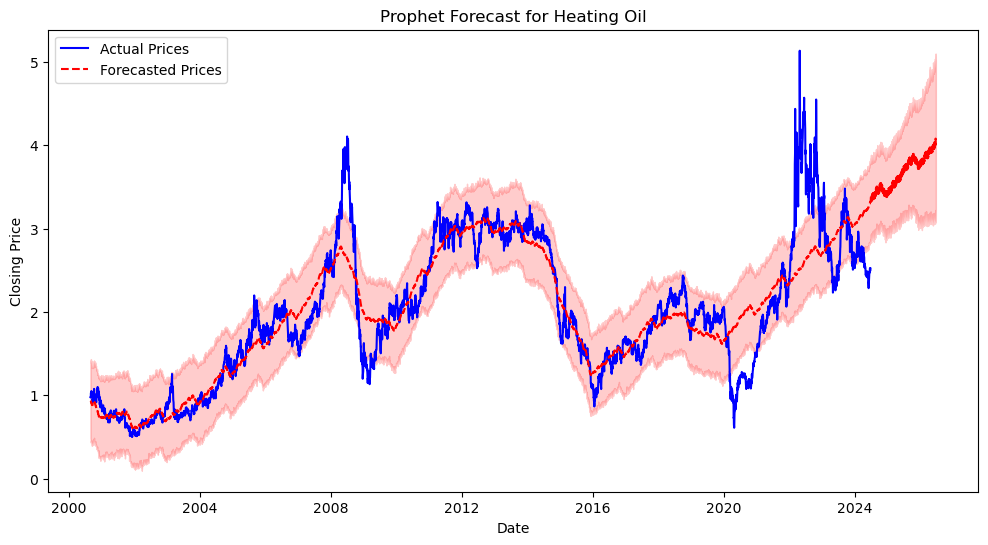

Forecasting for RBOB Gasoline using Prophet...


07:47:00 - cmdstanpy - INFO - Chain [1] start processing
07:47:02 - cmdstanpy - INFO - Chain [1] done processing


RBOB Gasoline - MAE: 1.79, RMSE: 1.86


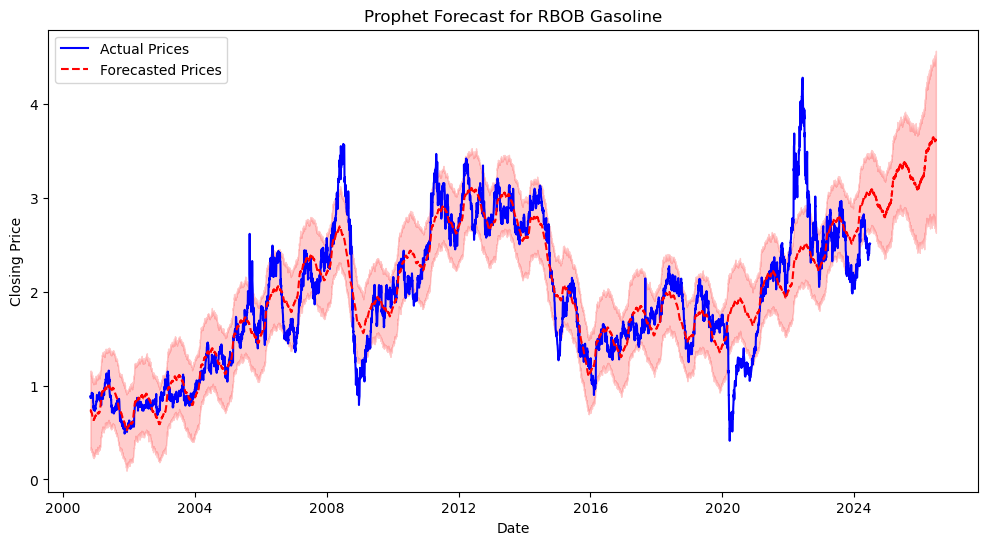

Forecasting for Brent Crude Oil using Prophet...


07:47:03 - cmdstanpy - INFO - Chain [1] start processing
07:47:04 - cmdstanpy - INFO - Chain [1] done processing


Brent Crude Oil - MAE: 11.07, RMSE: 13.13


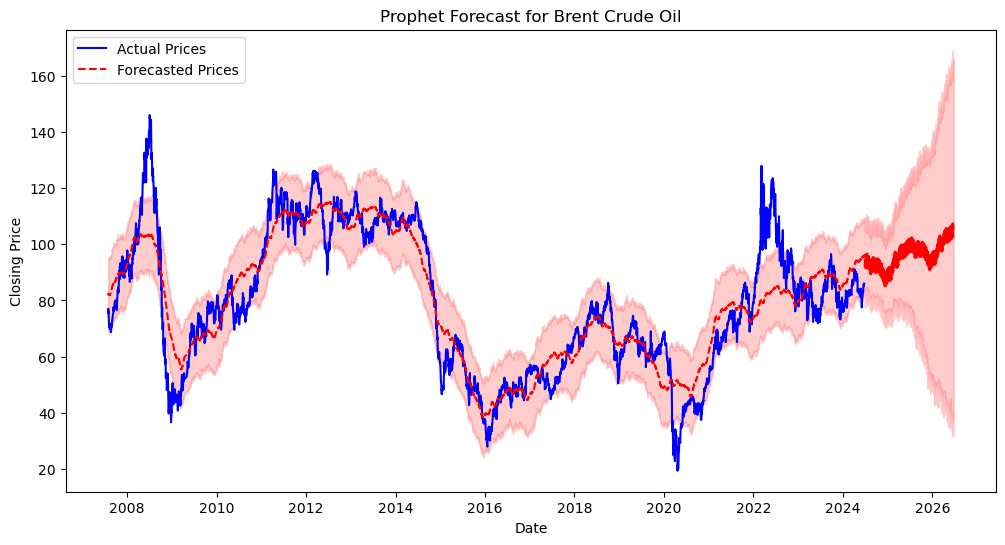

In [ ]:
for commodity in fuels_df['commodity'].unique():
    print(f"Forecasting for {commodity} using Prophet...")

    # Extract and rename necessary columns for Prophet
    commodity_data = fuels_df[fuels_df['commodity'] == commodity][['close']].reset_index()
    commodity_data.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

    # Train Prophet model with yearly and weekly seasonality
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.05)
    model.fit(commodity_data)

    # Generate 2-year future predictions
    future = model.make_future_dataframe(periods=forecast_horizon)
    forecast = model.predict(future)

    # Store forecast results
    prophet_forecasts[commodity] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # Evaluate forecast accuracy (MAE & RMSE)
    if len(commodity_data) > 730:
        actual = commodity_data['y'].iloc[-730:]
        predicted = forecast['yhat'].iloc[:730]

        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        print(f"{commodity} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Plot actual vs forecasted prices
    plt.figure(figsize=(12, 6))
    plt.plot(commodity_data['ds'], commodity_data['y'], label="Actual Prices", color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label="Forecasted Prices", linestyle='dashed', color='red')
    plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.2)
    plt.title(f"Prophet Forecast for {commodity}")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.show()


## Converting the forecasts to a Dataframe and Saving it to a new CSV file

In [69]:
# Combine all commodity forecasts
forecast_list = []

In [ ]:

for commodity, forecast in prophet_forecasts.items():
    forecast['commodity'] = commodity  # Add commodity column
    forecast_list.append(forecast)

forecast_df = pd.concat(forecast_list, axis=0).reset_index(drop=True)

# Rename columns for clarity
forecast_df.rename(columns={'ds': 'Date', 'yhat': 'Forecasted Price', 
                            'yhat_lower': 'Lower Bound', 'yhat_upper': 'Upper Bound'}, inplace=True)

# Save forecast with commodity column
forecast_df.to_csv("prophet_forecast_2years.csv", index=False)

print("Forecast successfully saved with commodity labels.")


Forecast successfully saved with commodity labels.


## Forecasted Closing Prices of Commodities Over Time
This visualization presents the forecasted closing prices of multiple commodities using the Prophet model. The forecast spans from the historical data until June 2026, capturing expected trends and fluctuations for different commodities. Each line represents a different commodity’s projected price movement, showing long-term patterns and market behaviors.

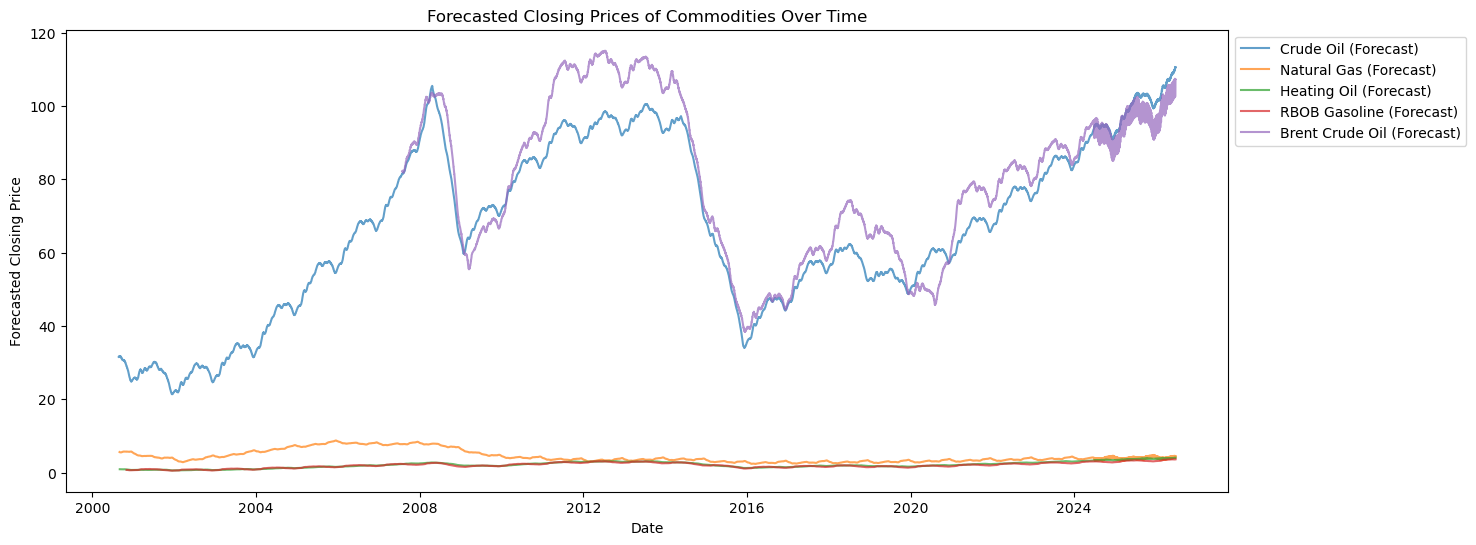

In [71]:
plt.figure(figsize=(15, 6))

for commodity in forecast_df['commodity'].unique():
    subset = forecast_df[forecast_df['commodity'] == commodity]
    plt.plot(subset['Date'], subset['Forecasted Price'], label=f"{commodity} (Forecast)", alpha=0.7)

plt.title("Forecasted Closing Prices of Commodities Over Time")
plt.xlabel("Date")
plt.ylabel("Forecasted Closing Price")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()


In [72]:
print(forecast_df['Date'].max())

2026-06-24 00:00:00


## Evaluation
For each commodity, MAE (which measures the average absolute difference between actual and predicted values) and RMSE (which penalizes larger errors) are calculated. The computed errors are then stored in lists for further analysis. The results provide insights into the model’s performance, helping to identify commodities with higher forecasting errors and areas for improvement.

In [73]:
# Initialize lists to store errors
mae_list = []
rmse_list = []

In [ ]:
# Compute error metrics for each commodity
for commodity in fuels_df['commodity'].unique():
    print(f"Evaluating forecast for {commodity}...")

    # Extract actual and predicted values
    commodity_data = fuels_df[fuels_df['commodity'] == commodity][['close']].reset_index()
    commodity_data.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

    if commodity in prophet_forecasts:
        forecast = prophet_forecasts[commodity]

        # Compare last 730 days of actual vs. first 730 days of forecasted values
        actual = commodity_data['y'].iloc[-730:]
        predicted = forecast['yhat'].iloc[:730]

        # Compute MAE & RMSE
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        print(f"{commodity} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

        # Store errors
        mae_list.append(mae)
        rmse_list.append(rmse)


Evaluating forecast for Crude Oil...
Crude Oil - MAE: 55.17, RMSE: 56.47
Evaluating forecast for Natural Gas...
Natural Gas - MAE: 1.78, RMSE: 2.16
Evaluating forecast for Heating Oil...
Heating Oil - MAE: 2.20, RMSE: 2.28
Evaluating forecast for RBOB Gasoline...
RBOB Gasoline - MAE: 1.79, RMSE: 1.86
Evaluating forecast for Brent Crude Oil...
Brent Crude Oil - MAE: 11.07, RMSE: 13.13


In [75]:
# Compute overall MAE and RMSE across all commodities
overall_mae = np.mean(mae_list)
overall_rmse = np.mean(rmse_list)

print(f"\nOverall Model Performance")
print(f"MAE (Mean Absolute Error): {overall_mae:.2f}")
print(f"RMSE (Root Mean Squared Error): {overall_rmse:.2f}")


Overall Model Performance**
MAE (Mean Absolute Error):** 14.40
RMSE (Root Mean Squared Error):** 15.18


## Conclusions (Model Results)
The provided visualizations showcase time series forecasting for various commodity prices, including crude oil, Brent crude oil, RBOB gasoline, heating oil, and natural gas, using Facebook's Prophet model. The trends reveal significant price fluctuations for crude oil and Brent crude oil, particularly sharp increases and decreases around the 2008 financial crisis and the 2020 COVID-19 pandemic. In contrast, natural gas, heating oil, and RBOB gasoline exhibit smaller, more stable price variations over time.

<br>The individual forecasts for each commodity indicate notable insights. For Brent crude oil, the forecast projects a steady price increase beyond 2024, with the confidence intervals widening, reflecting greater uncertainty in future predictions. RBOB gasoline and heating oil forecasts capture seasonal variations and suggest a gradual rise in prices. Natural gas, despite its historically high volatility, shows a moderate upward trend in the forecast. Crude oil prices, after a sharp dip in 2020, are expected to gradually increase, although the model's uncertainty grows significantly as predictions extend past 2025.

<br>The forecast extends until June 24, 2026, highlighting that while short-term predictions appear relatively reliable, long-term forecasts are accompanied by broader confidence intervals, indicating increased uncertainty. These projections align with historical patterns but must be approached cautiously, considering external factors like geopolitical events, supply chain disruptions, and broader economic shifts.The model provides a strong baseline for forecasting commodity prices, but the results underscore the importance of integrating additional data sources such as macroeconomic indicators, OPEC decisions, and geopolitical risks to enhance predictive accuracy. The wide confidence intervals suggest that while the model captures general trends, there is considerable uncertainty in long-term forecasts, warranting careful interpretation. Further evaluation of model accuracy and exploration of alternative forecasting methods could offer deeper insights into future commodity price movements.

## References
https://facebook.github.io/prophet/
<br>https://otexts.com/fpp3/prophet.html
<br>https://github.com/ajitsingh98/Time-Series-Analysis-and-Forecasting-with-Python
<br>https://github.com/thuml/Time-Series-Library
<br>https://www.tableau.com/analytics/time-series-forecasting#:~:text=Time%20Series%20Forecasting%3A%20Definition%2C%20Applications,drive%20future%20strategic%20decision%2Dmaking.
